# Movie Project
In 2019, I decided to copy my DVDs to harddisk so I can access them directly with my mediacenter when ever I want, without replacing the discs. Furthermore, I wanted to have some statistics, about the movie files and the movie titles.

The movie file information were collected on my Linux based NAS with the command mediainfo. The following command was used to generate the mediainfo.txt file which will be used during this project:

* \\$ find . -name "*.m4v" | sort | while read m; do mediainfo "${m}" >> ~/mediainfo.txt; done

Additionally I am using OMDb API (https://www.omdbapi.com/) to collect more data on my movies.

And yes I know, I have a weird taste in movies :)

## Part 1: Import modules & some default settings I like to use

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
# 3D Plots
from scipy.stats import kde
from mpl_toolkits.mplot3d import Axes3D

In [40]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
plt.rcParams['figure.autolayout'] = True
sns.set_style('darkgrid')
sns.set_palette('colorblind')
dc = '#1e88e5' # DEFAULT COLOR

## Part 2: accessing data

In [41]:
def load_mediainfo():
    """This function will load the content from the mediainfo.txt and store it in a CSV file to access it easily with pandas"""
    mediainfo_file = 'mediainfo.txt'
    mediainfo = []
    f = open(mediainfo_file)
    for line in f:
        mediainfo.append(line.strip())
    f.close()
    mediainfo.append('General')
    mediadict = {}
    tmp_dict = {}
    section = ''
    for line in mediainfo:
        split_line = line.split(':')
        if len(split_line) == 1 and line != '':
            section = line.strip().lower().replace(' ', '_').replace('#', '') + '_'
        if line == 'General':
            #print(len(mediadict.keys()), len(tmp_dict.keys()))
            #if len(tmp_dict.keys()) == 0 and len(mediadict.keys()) == 0:
            #    print('NOTHING')
            
            if len(tmp_dict.keys()) != 0 and len(mediadict.keys()) == 0:
                mediadict = tmp_dict
                tmp_dict = {}
            
            if len(tmp_dict.keys()) != 0 and len(mediadict.keys()) != 0:
                # FIRST CHECK IF ALL KEYS ARE IN DICT:
                for tk in tmp_dict.keys():
                    if tk not in mediadict:
                        # FOREACH NEW KEY, ADD TO mediadict AND FILL WITH EMPTY VALUES:
                        key_list = list(mediadict.keys()) # LIST OF AVAILABLE KEYS
                        lv = len(mediadict[key_list[0]])  # LENGTH OF FIRST LIST
                        tmp_list = []                     # EMPTY LIST
                        for tc in range(0, lv):
                            tmp_list.append('')           # ADD EMPTY VALUES TO TEMP LIST
                        mediadict[tk] = tmp_list
                # AT THIS POINT ALL KEYS ARE AVAILABLE, NOW ADD VALUES FROM tmp_dict TO mediadict
                for tk in tmp_dict.keys():
                    mediadict[tk].append(tmp_dict[tk][0])
                # SOMETIMES A MOVIE IS MISSING SOME INFORMATION,
                # AT THIS POINT MISSING INFORMATION MUST BE ADDED BY ADDING AN EMPTY VALUE
                # GET ALL LIST LENGTHS
                max_val = 0
                for tk in mediadict.keys():
                    if len(mediadict[tk]) > max_val:
                        max_val = len(mediadict[tk])
                for tk in mediadict.keys():
                    while len(mediadict[tk]) < max_val:
                        mediadict[tk].append('')
            tmp_dict = {}
        else:
            if len(split_line) > 1:
                attr = section + split_line[0].strip().lower().replace(' ', '_')
                valu = split_line[1:]
                svalu = ':'.join(valu).strip()
                tmp_dict[attr] = [svalu]
    #print(mediadict)
    df = pd.DataFrame(mediadict)
    # WHEN THE CONTENT OF THE mediainfo.txt IS AVAILABLE AS A DATAFRAME, THE NAMES CAN BE ADJUSTED
    # EVEN THOUGH THIS IS MORE OF A CLEANING ACTIVITY, I WILL ADJUST NAMES DIRECTLY
    df['general_complete_name_clean'] = df['general_complete_name']
    df.replace({'general_complete_name_clean': r'.m4v$'}, {'general_complete_name_clean': ''}, regex=True, inplace=True)
    df.replace({'general_complete_name_clean': r'.*/'}, {'general_complete_name_clean': ''}, regex=True, inplace=True)
    return df

In [42]:
# IF THE FILE mediainfo.csv IS ALREADY AVAILABLE, THIS STEP CAN BE SKIPPED
#df = load_mediainfo()
#df.to_csv('mediainfo.csv', index=False)
#df[['general_complete_name', 'general_complete_name_clean']].sample(5)

In [43]:
def load_omdbapi():
    df_mi = pd.read_csv('mediainfo.csv')
    #movies = list(df_mi['general_complete_name_clean'].sample(3))
    movies = list(df_mi['general_complete_name_clean'])
    apikey = ''
    mov_info = []
    mov_url = []
    for mov in movies:
        filename = mov
        mov = mov.lower().replace(' ', '+')
        url = 'http://www.omdbapi.com/?apikey=' + apikey + '&t=' + mov
        mov_url.append(url)
        #print(mov, url)
        r = requests.get(url)
        mov_info.append(r.json())
        mov_info[-1]['API URL'] = url
        mov_info[-1]['Filename'] = filename

    # CREATE A SET FOR ALL KEYS TO HAVE UNIQUE KEYS
    keyset = set()
    for m in mov_info:
        for k in m.keys():
            keyset.add(k)
    # CREATE A LIST FOR ALL VALUES WITH EMPTY DICTIONARIES AS KEYS
    a = []
    for k in keyset:
        a.append({k: []})
    # GO THROUGH ALL RECEIVED LINES, EXTRACT THE VALUE(S) AND ADD TO THE DICTIONARY INSIDE THE LIST
    for mov_line in mov_info:
        for c, dictionary in enumerate(a):
            for key in dictionary.keys():
                if key in mov_line:
                    #print('PASS', c, key)
                    a[c][key].append(mov_line[key])
                else:
                    #print('FAIL', c, key)
                    a[c][key].append('')

    df = pd.DataFrame()
    for col in a:
        for key in col.keys():
            df[key] = col[key]
    return df

In [44]:
#df = load_omdbapi()
#df.to_csv('omdbapi.csv', index=False)

## Part 3: data cleaning

In [45]:
df = pd.read_csv('mediainfo.csv')
df_omdb = pd.read_csv('omdbapi.csv')
print(df.shape, df_omdb.shape)

(106, 180) (106, 29)


In [46]:
# DEDICATED DATAFRAME FOR THE GENERAL SECTION
all_col = list(df.columns)
gen_col = []
for col in all_col:
    if col[0:7] == 'general':
        gen_col.append(col)
df_gen = df[gen_col].copy()
#df_gen.info()
df_gen.sample(3)

,general_complete_name,general_format,general_format_profile,general_codec_id,general_file_size,general_duration,general_overall_bit_rate,general_movie_name,general_encoded_date,general_tagged_date,general_writing_application,general_genre,general_recorded_date,general_cover,general_overall_bit_rate_mode,general_gsst,general_gstd,general_complete_name_clean
48,./Once Upon a Time in America/Once Upon A Time...,MPEG-4,Base Media / Version 2,mp42 (isom/iso2/avc1/mp41),994 MiB,1 h 44 min,1 328 kb/s,ONCE_UPON_A_TIME_IN_AMERICA,UTC 2019-10-12 12:00:41,UTC 2019-10-12 12:00:41,HandBrake 1.2.2 2019022400,NaN,NaN,NaN,NaN,NaN,NaN,Once Upon A Time In America (Disc 2)
50,./Pitch Black/Pitch Black.m4v,MPEG-4,Base Media / Version 2,mp42 (isom/iso2/avc1/mp41),756 MiB,1 h 43 min,1 019 kb/s,PITCH_BLACK,UTC 2019-12-08 13:24:51,UTC 2019-12-08 13:24:51,HandBrake 1.2.2 2019022400,NaN,NaN,NaN,NaN,NaN,NaN,Pitch Black
73,./The Butterfly Effect/2004.01 The Butterfly E...,MPEG-4,Base Media / Version 2,mp42 (isom/iso2/avc1/mp41),985 MiB,1 h 48 min,1 263 kb/s,BUTTERFLY_EFFECT,UTC 2019-11-24 18:07:05,UTC 2019-11-24 18:07:05,HandBrake 1.2.2 2019022400,NaN,NaN,NaN,NaN,NaN,NaN,The Butterfly Effect


In [47]:
# DEDICATED DATAFRAME FOR THE VIDEO SECTION
all_col = list(df.columns)
vid_col = []
for col in all_col:
    if col[0:5] == 'video':
        vid_col.append(col)
df_vid = df[vid_col].copy()
#df_vid.info()
df_vid.sample(3)

,video_id,video_format,video_format/info,video_format_profile,"video_format_settings,_cabac","video_format_settings,_reframes",video_codec_id,video_codec_id/info,video_duration,video_bit_rate,...,video_tagged_date,video_color_range,video_color_primaries,video_transfer_characteristics,video_matrix_coefficients,video_menus,video_original_display_aspect_ratio,video_standard,"video_format_settings,_gop",video_title
34,1,AVC,Advanced Video Codec,Main@L4,Yes,4 frames,avc1,Advanced Video Coding,1 h 52 min,821 kb/s,...,UTC 2019-11-18 17:29:40,Limited,BT.601 PAL,BT.709,BT.601,3.0,NaN,NaN,NaN,NaN
14,1,AVC,Advanced Video Codec,Main@L4,Yes,4 frames,avc1,Advanced Video Coding,1 h 22 min,609 kb/s,...,UTC 2019-11-30 09:44:28,Limited,BT.601 PAL,BT.709,BT.601,3.0,NaN,NaN,NaN,NaN
53,1,AVC,Advanced Video Codec,Main@L4,Yes,4 frames,avc1,Advanced Video Coding,1 h 28 min,844 kb/s,...,UTC 2019-11-17 16:57:49,Limited,BT.601 PAL,BT.709,BT.601,3.0,NaN,NaN,NaN,NaN


### general_file_size
Contains ambiguous values, good to read but bad for stats (79.3 MiB, 1.07 GiB, ...). Will be converted to int and unit MB

In [48]:
df_gen['general_file_size_new'] = df_gen['general_file_size']
df_gen.replace({'general_file_size_new': r' MiB$'}, {'general_file_size_new': ''}, regex=True, inplace=True)
df_gen.replace({'general_file_size_new': r' GiB$'}, {'general_file_size_new': ''}, regex=True, inplace=True)
df_gen.replace({'general_file_size_new': r' '}, {'general_file_size_new': ''}, regex=True, inplace=True)
df_gen = df_gen.astype({'general_file_size_new':'float'})
mask = df_gen['general_file_size'].str.contains(' GiB')
# df_gen.loc[mask, 'general_file_size_new'] = df_gen['general_file_size_new'] * 1024
df_gen.loc[mask, 'general_file_size_new'] *= 1024

In [49]:
df_gen[['general_file_size', 'general_file_size_new']].sample(3)

,general_file_size,general_file_size_new
66,585 MiB,585.0
65,694 MiB,694.0
20,1.05 GiB,1075.2


### general_duration
Contains ambiguous values, good to read but bad for stats (2 h 27 min, 16 min 49 s, ...) Will be converted to Minutes (Seconfds are ignored)

In [50]:
df_gen['general_duration_new'] = df_gen['general_duration']
df_gen.replace({'general_duration_new': r' min$'}, {'general_duration_new': ':00'}, regex=True, inplace=True)
df_gen.replace({'general_duration_new': r' s$'}, {'general_duration_new': ''}, regex=True, inplace=True)
df_gen.replace({'general_duration_new': r' h '}, {'general_duration_new': ':'}, regex=True, inplace=True)
df_gen.replace({'general_duration_new': r' min '}, {'general_duration_new': ':'}, regex=True, inplace=True)
df_gen['general_duration_new'] = df_gen['general_duration_new'].apply(lambda x: x if len(x) > 5 else '0:' + x)
df_gen['general_duration_new'] = pd.to_datetime(df_gen['general_duration_new'].str.strip(), format='%H:%M:%S')
df_gen['general_duration_hour'] = pd.DatetimeIndex(df_gen['general_duration_new']).hour
df_gen['general_duration_minute'] = pd.DatetimeIndex(df_gen['general_duration_new']).minute
df_gen['general_runtime'] = (df_gen['general_duration_hour'] * 60) + df_gen['general_duration_minute']
df_gen[['general_duration', 'general_duration_new', 'general_duration_hour', 'general_duration_minute', 'general_runtime']].info()
#df_gen[['general_duration', 'general_duration_new']].sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 5 columns):
general_duration           106 non-null object
general_duration_new       106 non-null datetime64[ns]
general_duration_hour      106 non-null int64
general_duration_minute    106 non-null int64
general_runtime            106 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.3+ KB


In [51]:
df_gen[['general_duration', 'general_duration_new', 'general_runtime']].sample(10)

,general_duration,general_duration_new,general_runtime
0,2 h 22 min,1900-01-01 02:22:00,142
80,16 min 43 s,1900-01-01 00:16:43,16
62,1 h 48 min,1900-01-01 01:48:00,108
4,1 h 51 min,1900-01-01 01:51:00,111
28,2 h 16 min,1900-01-01 02:16:00,136
105,1 h 42 min,1900-01-01 01:42:00,102
57,1 h 40 min,1900-01-01 01:40:00,100
48,1 h 44 min,1900-01-01 01:44:00,104
45,1 h 51 min,1900-01-01 01:51:00,111
25,1 h 37 min,1900-01-01 01:37:00,97


In [52]:
df_gen['general_runtime'].describe()

count    106.000000
mean      94.801887
std       36.554309
min        2.000000
25%       87.000000
50%      100.000000
75%      111.000000
max      179.000000
Name: general_runtime, dtype: float64

### general_overall_bit_rate

In [53]:
df_gen.replace({'general_overall_bit_rate': r' kb/s$'}, {'general_overall_bit_rate': ''}, regex=True, inplace=True)
df_gen.replace({'general_overall_bit_rate': r' '}, {'general_overall_bit_rate': ''}, regex=True, inplace=True)
df_gen = df_gen.astype({'general_overall_bit_rate':'int'})
df_gen['general_overall_bit_rate'].sample(3)

50    1019
32    1527
12    1089
Name: general_overall_bit_rate, dtype: int64

### video_width & video_height
Remove trailing pixels and convert to int

In [54]:
df_vid.replace({'video_width': r' pixels$'}, {'video_width': ''}, regex=True, inplace=True)
df_vid.replace({'video_width': r' '}, {'video_width': ''}, regex=True, inplace=True)
df_vid.replace({'video_height': r' pixels$'}, {'video_height': ''}, regex=True, inplace=True)
df_vid.replace({'video_height': r' '}, {'video_height': ''}, regex=True, inplace=True)
df_vid = df_vid.astype({'video_width':'int', 'video_height':'int'})
df_vid[['video_width', 'video_height']].sample(3)

,video_width,video_height
8,718,570
60,716,576
18,702,436


### imdbRating & imdbVotes

In [55]:
df_omdb.replace({'imdbVotes': r','}, {'imdbVotes': ''}, regex=True, inplace=True)
df_omdb['imdbRating'].fillna(0, inplace=True)
df_omdb['imdbVotes'].fillna(0, inplace=True)
df_omdb = df_omdb.astype({'imdbVotes':'int'})
df_omdb[['imdbRating', 'imdbVotes']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
imdbRating    106 non-null float64
imdbVotes     106 non-null int64
dtypes: float64(1), int64(1)
memory usage: 1.8 KB


### Released and DVD
Both columns are a string of format 01 Jan 1990, will be converted to a proper date format like 1990-01-01

In [56]:
#df_omdb.columns
#df_omdb[['Released', 'DVD']]
for c, m in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']):
    cm = c+1
    cms = ''
    if cm < 10:
        cms = '.0' + str(cm) + '.'
    else:
        cms =  '.' + str(cm) + '.'
    m = ' ' + m + ' '
    #print(m, cms)
    df_omdb.replace({'Released': r'' + m}, {'Released': cms}, regex=True, inplace=True)
    df_omdb.replace({'DVD': r'' + m}, {'DVD': cms}, regex=True, inplace=True)
df_omdb['Released'] = pd.to_datetime(df_omdb['Released'])
df_omdb['DVD'] = pd.to_datetime(df_omdb['DVD'])
df_omdb['ReleasedYear'] = pd.DatetimeIndex(df_omdb['Released']).year
df_omdb['ReleasedMonth'] = pd.DatetimeIndex(df_omdb['Released']).month
df_omdb['DVDYear'] = pd.DatetimeIndex(df_omdb['DVD']).year
df_omdb['DVDMonth'] = pd.DatetimeIndex(df_omdb['DVD']).month
df_omdb[['Released', 'ReleasedYear', 'ReleasedMonth', 'DVD', 'DVDYear', 'DVDMonth']].sample(3)

,Released,ReleasedYear,ReleasedMonth,DVD,DVDYear,DVDMonth
5,2005-01-28,2005.0,1.0,2005-10-05,2005.0,10.0
58,1995-07-07,1995.0,7.0,2001-07-17,2001.0,7.0
18,2001-01-19,2001.0,1.0,2003-04-02,2003.0,4.0


## Part 4: Charts - General

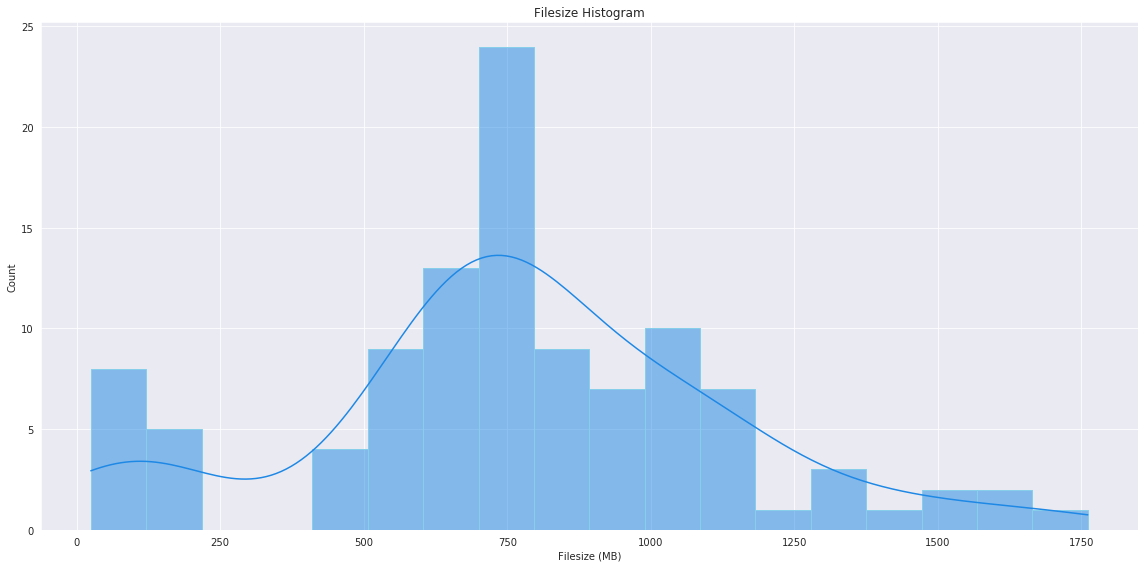

In [57]:
bins = int(round(df_gen['general_file_size_new'].max()/100, 0))
sns.histplot(df_gen['general_file_size_new'], bins=bins, kde=True, color=dc, edgecolor='skyblue')
plt.title('Filesize Histogram')
plt.xlabel('Filesize (MB)')
plt.ylabel('Count')
plt.show()

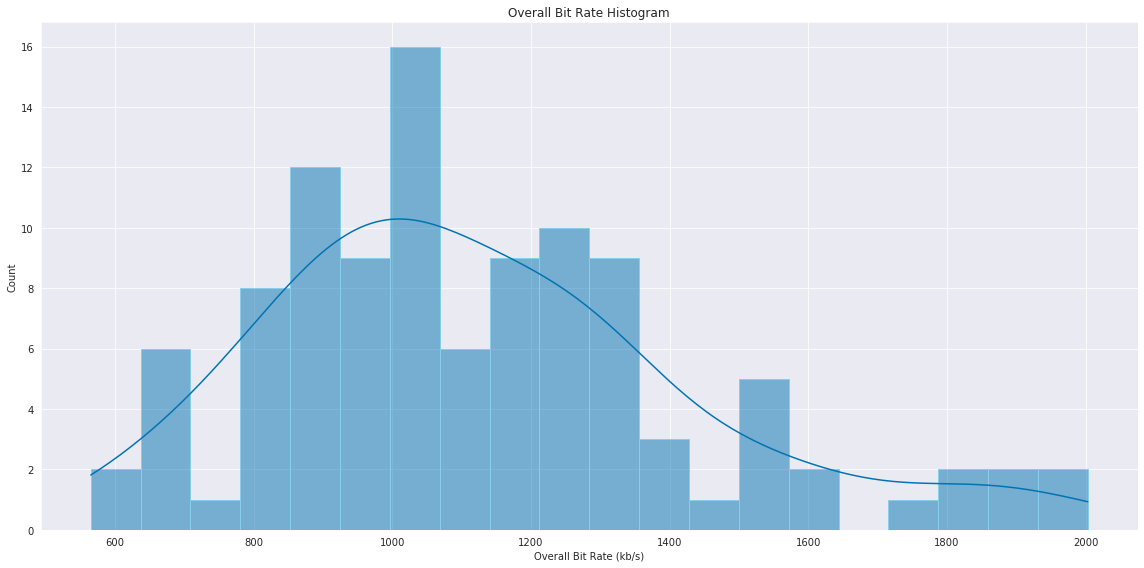

In [58]:
bins = int(round(df_gen['general_overall_bit_rate'].max()/100, 0))
sns.histplot(df_gen['general_overall_bit_rate'], bins=bins, kde=True, edgecolor='skyblue')
plt.title('Overall Bit Rate Histogram')
plt.xlabel('Overall Bit Rate (kb/s)')
plt.ylabel('Count')
plt.show()

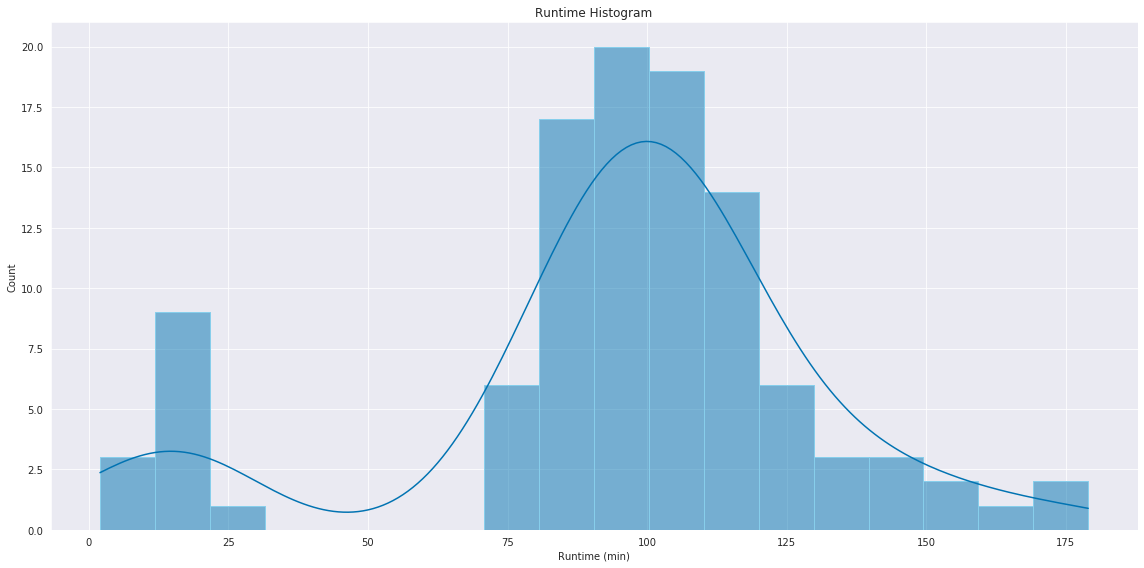

In [59]:
bins = int(round(df_gen['general_runtime'].max()/10, 0))
sns.histplot(df_gen['general_runtime'], bins=bins, kde=True, edgecolor='skyblue')
plt.title('Runtime Histogram')
plt.xlabel('Runtime (min)')
plt.ylabel('Count')
plt.show()

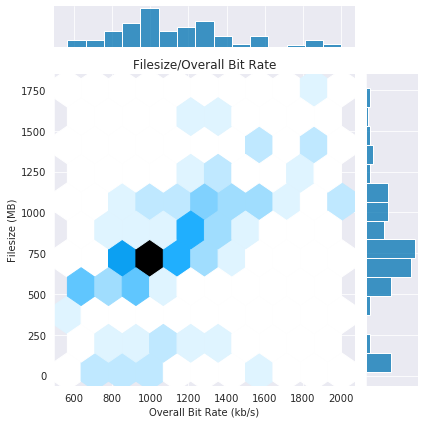

In [60]:
sns.jointplot(x=df_gen['general_overall_bit_rate'], y=df_gen['general_file_size_new'], kind='hex', palette='colorblind', marginal_kws=dict(bins=15, fill=True))
plt.title('Filesize/Overall Bit Rate')
plt.xlabel('Overall Bit Rate (kb/s)')
plt.ylabel('Filesize (MB)')
plt.show()

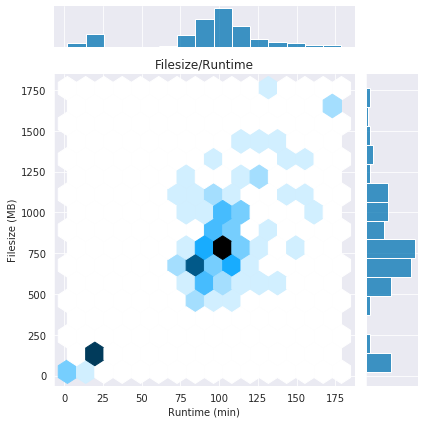

In [61]:
sns.jointplot(x=df_gen['general_runtime'], y=df_gen['general_file_size_new'], kind='hex', palette='colorblind', marginal_kws=dict(bins=15, fill=True))
plt.title('Filesize/Runtime')
plt.xlabel('Runtime (min)')
plt.ylabel('Filesize (MB)')
plt.show()

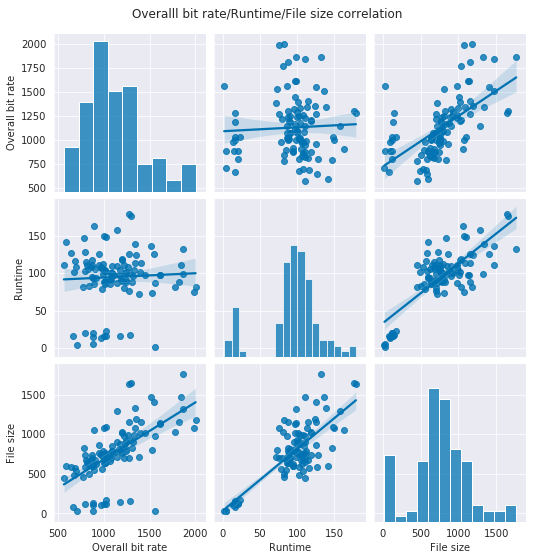

In [62]:
df_tmp = df_gen[['general_overall_bit_rate', 'general_runtime', 'general_file_size_new']].copy()
df_tmp.rename(columns={'general_overall_bit_rate': 'Overall bit rate', 'general_runtime': 'Runtime', 'general_file_size_new': 'File size'}, inplace=True)
sns.pairplot(df_tmp, kind='reg')
plt.suptitle('Overalll bit rate/Runtime/File size correlation', y=1.03)
plt.show()

## Part 4: Charts - Video

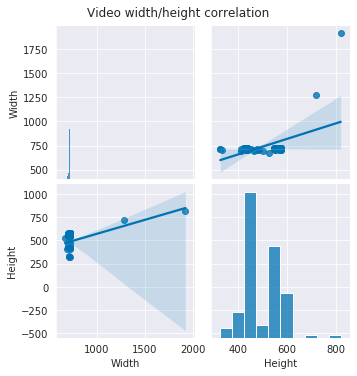

In [63]:
df_tmp = df_vid[['video_width', 'video_height']].copy()
df_tmp.rename(columns={'video_width': 'Width', 'video_height': 'Height'}, inplace=True)
sns.pairplot(df_tmp, kind='reg')
plt.suptitle('Video width/height correlation', y=1.03)
plt.show()

## Part 4: Charts - OMDB

In [64]:
df_omdb.columns

Index(['Year', 'DVD', 'Plot', 'totalSeasons', 'Response', 'Released', 'Awards',
       'Genre', 'Error', 'Ratings', 'Production', 'imdbID', 'API URL',
       'Runtime', 'Actors', 'Filename', 'Poster', 'Title', 'Language',
       'Director', 'Rated', 'BoxOffice', 'Type', 'Metascore', 'imdbRating',
       'Country', 'imdbVotes', 'Website', 'Writer', 'ReleasedYear',
       'ReleasedMonth', 'DVDYear', 'DVDMonth'],
      dtype='object')

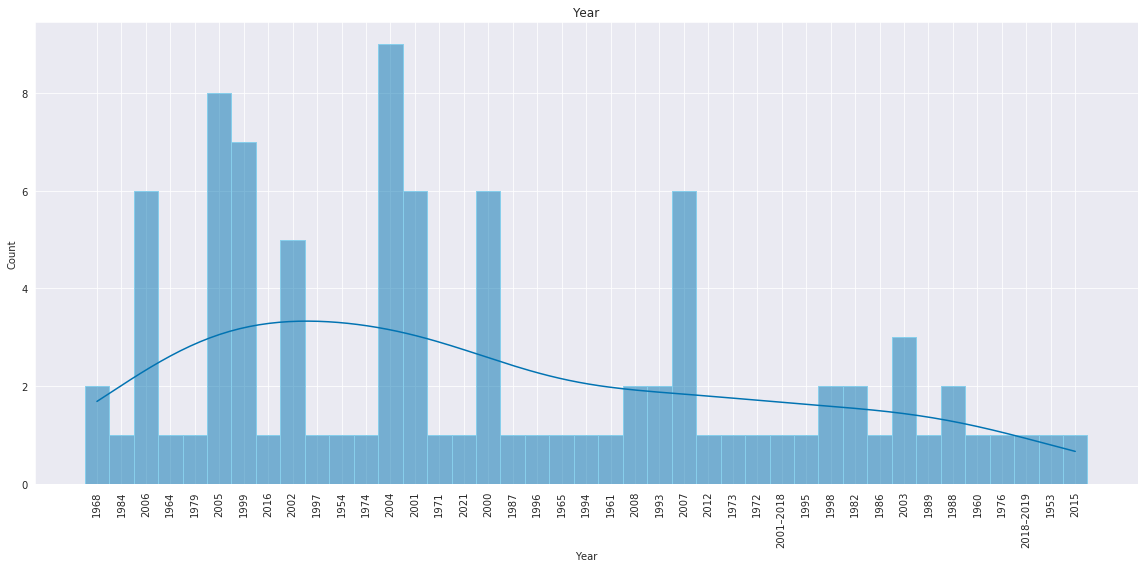

In [65]:
#bins = int(round(df_omdb['Country'].max()/10, 0))
sns.histplot(df_omdb['Year'], kde=True, edgecolor='skyblue')
plt.title('Year')
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

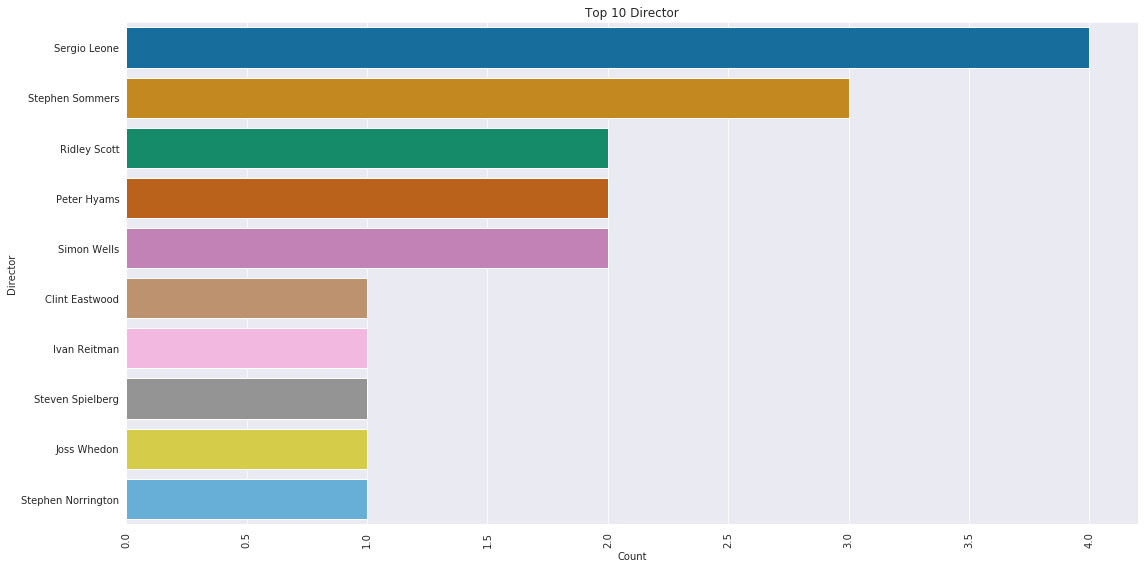

In [66]:
df_tmp = df_omdb['Director'].value_counts()
sns.barplot(x = df_tmp.head(10).values, y = df_tmp.head(10).index)
plt.title('Top 10 Director')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.ylabel('Director')
plt.show()

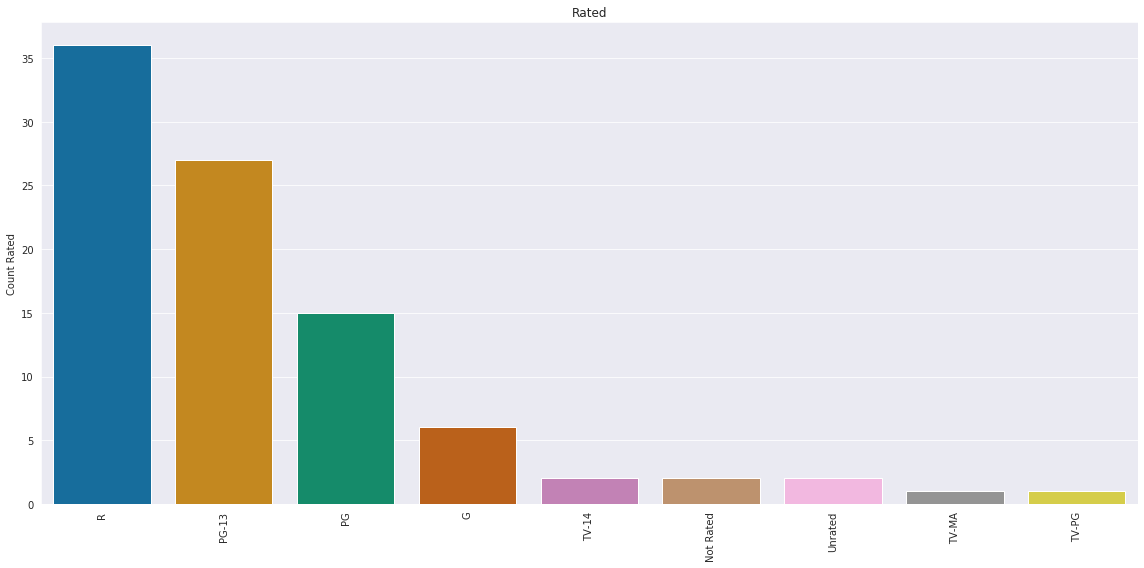

In [67]:
df_ser = df_omdb['Rated'].value_counts()
g1 = sns.barplot(x = df_ser.index, y = df_ser.values, palette='colorblind')
plt.xticks(rotation = 90)
plt.title('Rated')
plt.ylabel('Count Rated')
plt.show()

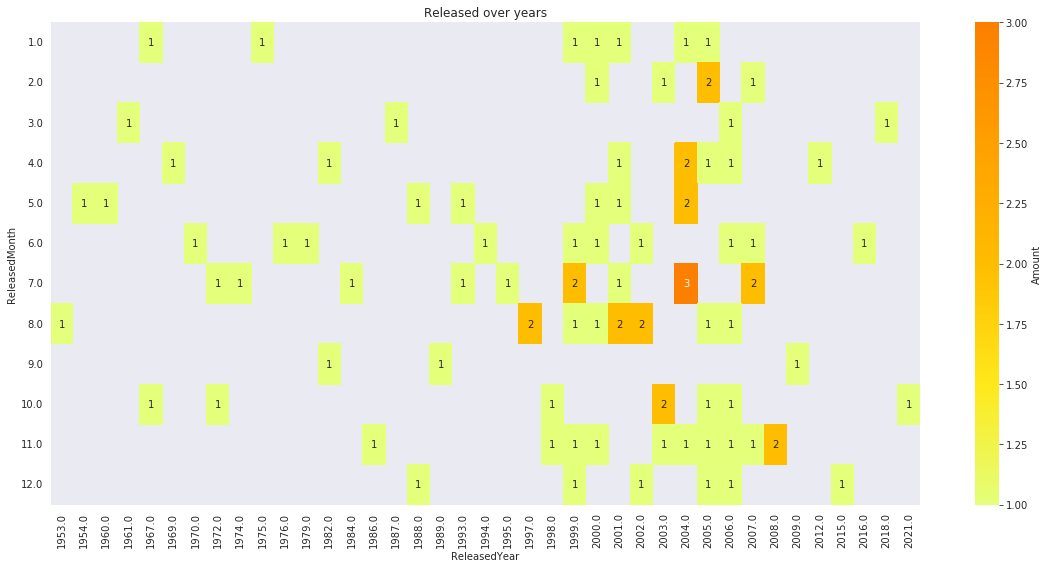

In [68]:
df_omdb['Amount'] = 1
tmp_pivot = pd.pivot_table(df_omdb, index='ReleasedMonth', columns='ReleasedYear', values='Amount', aggfunc=np.sum)
g1 = sns.heatmap(data=tmp_pivot, cmap='Wistia', annot=True, fmt='.20g', cbar_kws={'label': 'Amount'})
plt.yticks(rotation=0)
plt.title('Released over years')
plt.show()

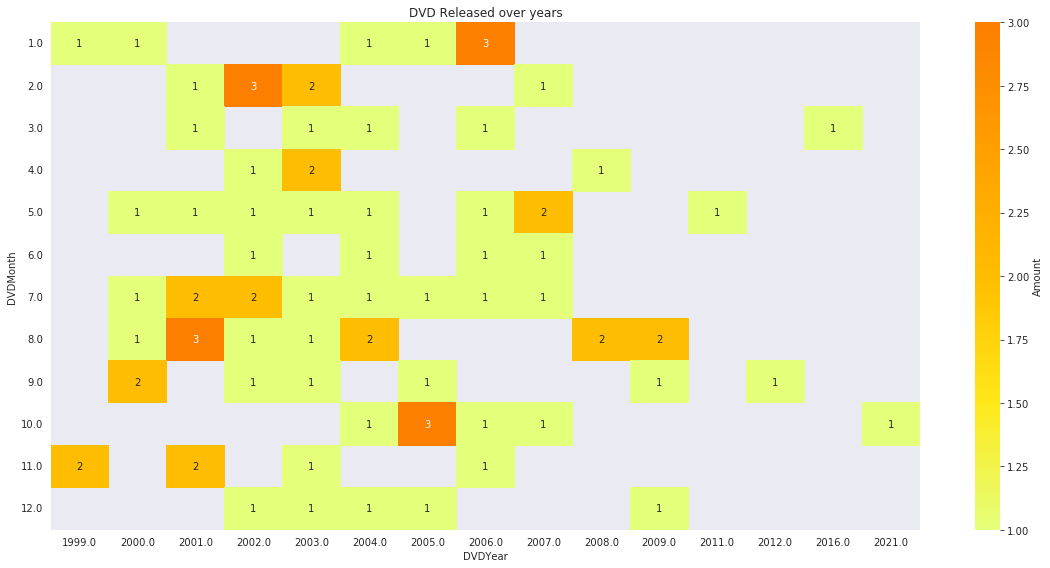

In [69]:
tmp_pivot = pd.pivot_table(df_omdb, index='DVDMonth', columns='DVDYear', values='Amount', aggfunc=np.sum)
g1 = sns.heatmap(data=tmp_pivot, cmap='Wistia', annot=True, cbar_kws={'label': 'Amount'})
plt.yticks(rotation=0)
plt.title('DVD Released over years')
plt.show()

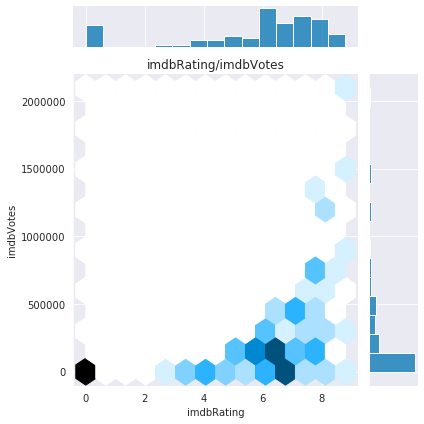

In [70]:
sns.jointplot(x=df_omdb['imdbRating'], y=df_omdb['imdbVotes'], kind='hex', palette='colorblind', marginal_kws=dict(bins=15, fill=True))
plt.title('imdbRating/imdbVotes')
plt.xlabel('imdbRating')
plt.ylabel('imdbVotes')
plt.show()

## Part 4: Charts - 3D
The following code is deactivated and only a demo. When executed, the functions will create 36 png images which can be assembled into gif with the following command:

* convert -delay 20 -loop 0 *.png myimage.gif

The code for the 3D charts was heavy inspired by https://www.python-graph-gallery.com/

In [71]:
 def runtime_filesize_3d():
    # ['general_overall_bit_rate', 'general_runtime', 'general_file_size_new']
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins=300
    k = kde.gaussian_kde([df_gen.general_runtime, df_gen.general_file_size_new])
    xi, yi = np.mgrid[df_gen.general_runtime.min():df_gen.general_runtime.max():nbins*1j, df_gen.general_file_size_new.min():df_gen.general_file_size_new.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Transform it in a dataframe
    data = pd.DataFrame({'x': xi.flatten(), 'y': yi.flatten(), 'z': zi })

    # Make the plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data.x, data.y, data.z, cmap=plt.cm.nipy_spectral, linewidth=0.2)

    for s in range(10, 370, 10):
        s_str = ''
        if s < 100:
            s_str = '0' + str(s)
        else:
            s_str = str(s)
        ax.view_init(45, s)
        fig.savefig(s_str + '.png')

#runtime_filesize_3d()

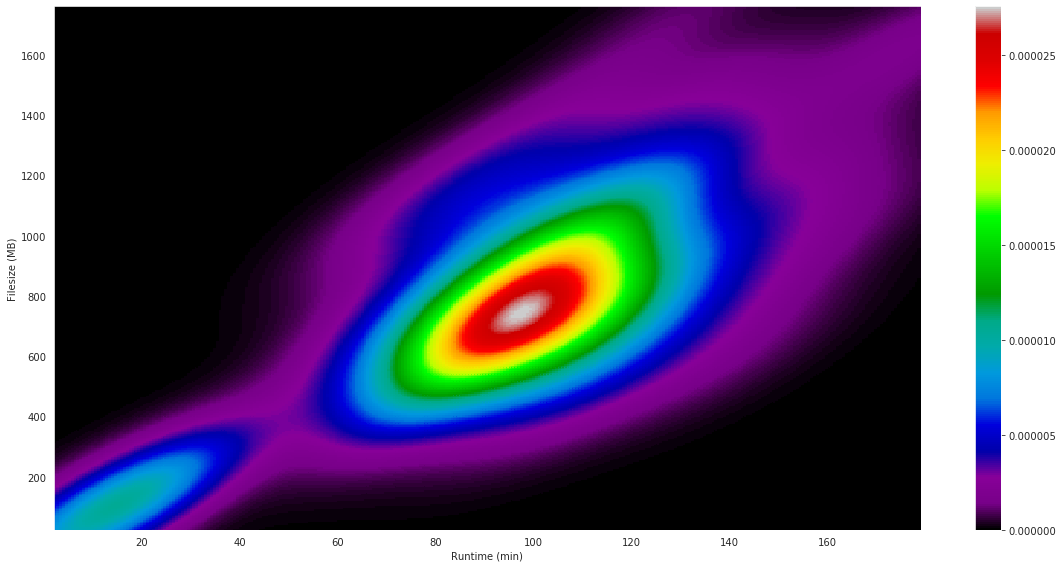

In [72]:
x = df_gen.general_runtime
y = df_gen.general_file_size_new
nbins=300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading = 'auto', cmap=plt.cm.nipy_spectral)
plt.colorbar()
plt.xlabel('Runtime (min)')
plt.ylabel('Filesize (MB)')
plt.show()

![runtime_vs_filesize.gif](runtime_vs_filesize/runtime_vs_filesize.gif)

In [73]:
def video_height_3d():
    nbins=300
    k = kde.gaussian_kde([df_vid.video_width, df_vid.video_height])
    xi, yi = np.mgrid[df_vid.video_width.min():df_vid.video_width.max():nbins*1j, df_vid.video_height.min():df_vid.video_height.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Transform it in a dataframe
    data = pd.DataFrame({'x': xi.flatten(), 'y': yi.flatten(), 'z': zi })

    # Make the plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data.x, data.y, data.z, cmap=plt.cm.nipy_spectral, linewidth=0.2)

    for s in range(10, 370, 10):
        s_str = ''
        if s < 100:
            s_str = '0' + str(s)
        else:
            s_str = str(s)
        ax.view_init(45, s)
        fig.savefig(s_str + '.png')

#video_height_3d()

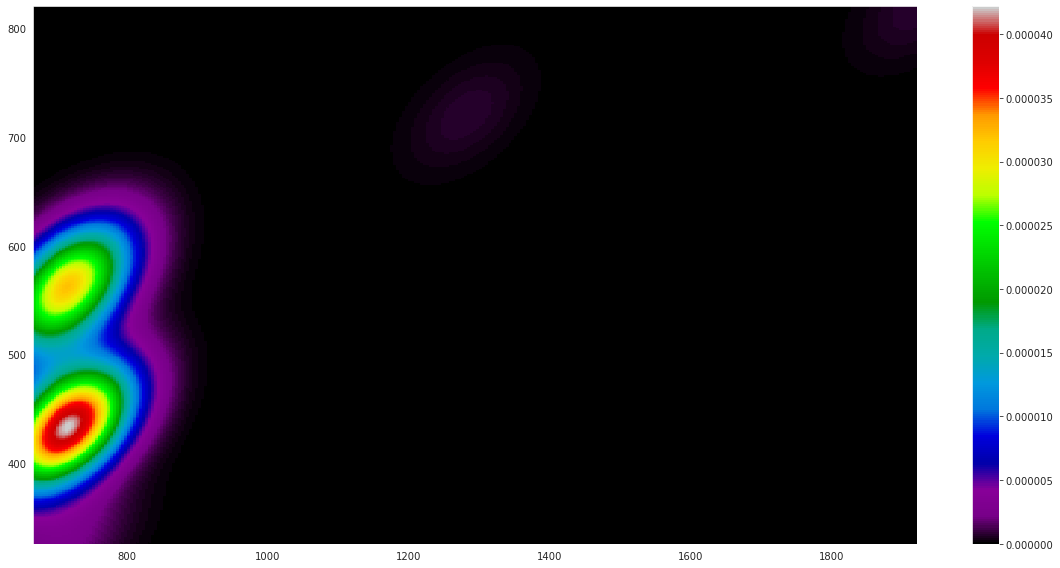

In [74]:
x = df_vid.video_width
y = df_vid.video_height
nbins=300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading = 'auto', cmap=plt.cm.nipy_spectral)
plt.colorbar()
plt.show()

![width_vs_height.gif](width_vs_height/width_vs_height.gif)

In [75]:
def imdbRating_imdbVotes_3d():
    nbins=300
    k = kde.gaussian_kde([df_omdb.imdbRating, df_omdb.imdbVotes])
    xi, yi = np.mgrid[df_omdb.imdbRating.min():df_omdb.imdbRating.max():nbins*1j, df_omdb.imdbVotes.min():df_omdb.imdbVotes.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Transform it in a dataframe
    data = pd.DataFrame({'x': xi.flatten(), 'y': yi.flatten(), 'z': zi })

    # Make the plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(data.x, data.y, data.z, cmap=plt.cm.nipy_spectral, linewidth=0.2)

    for s in range(10, 370, 10):
        s_str = ''
        if s < 100:
            s_str = '0' + str(s)
        else:
            s_str = str(s)
        ax.view_init(45, s)
        fig.savefig(s_str + '.png')

#imdbRating_imdbVotes_3d()

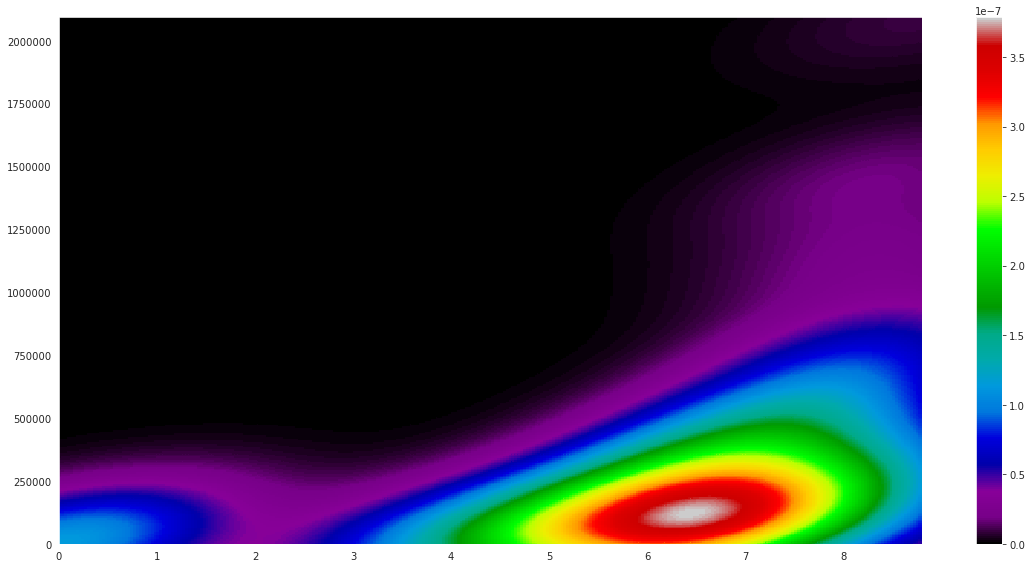

In [76]:
x = df_omdb.imdbRating
y = df_omdb.imdbVotes
nbins=300
k = kde.gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading = 'auto', cmap=plt.cm.nipy_spectral)
plt.colorbar()
plt.show()

![imdbRating_imdbVotes.gif](imdbRating_imdbVotes/imdbRating_imdbVotes.gif)